*[Original source code of this notebook can be found here](https://www.kaggle.com/code/alekseishamenev/is-it-a-bird-creating-a-model-from-your-own-data)*

This is a notebook inspired from the same-named notebook at kaggle, created for the fast.ai book. The original kaggle exercise is not working correctly (mainly problems with the duckduckgo_search library) so this is an attempt to make it work in 2024.

Make sure to select "Always use latest environment" under Session Options/Environment at the bottom right corner.

## Is it a bird?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367
import socket
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error:
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Firstly, we'll need to install some libraries. This may take a few minutes.

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai icrawler

## Step 1: Download images of birds and non-birds

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](https://imgs.xkcd.com/comics/tasks.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

This is just some code for setting up the crawler that'll get us images from the internet.

It's not necessary for training our model so you can skip this block if you're not interested.

In [3]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

Apart from the crawler, we'll also set up a search_images function for the sake of ease. This function will get images from the internet and download it.

In [4]:
# We'll define a search_images function for the sake of ease

def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name}, 
    )
    crawler.crawl(keyword=term, max_num=max_images)

Let's start by searching for a bird photo and seeing what kind of result we get.

In [5]:
# Folder name where to save downloaded pictures for model training/tuning
modelRootFolder = "../models/chapter1/bird_or_not"
search_images("bird", 1, modelRootFolder)

2024-10-17 22:13:15,641 - INFO - icrawler.crawler - start crawling...
2024-10-17 22:13:15,642 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-17 22:13:15,643 - INFO - feeder - thread feeder-001 exit
2024-10-17 22:13:15,644 - INFO - icrawler.crawler - starting 1 parser threads...
2024-10-17 22:13:15,645 - INFO - icrawler.crawler - starting 1 downloader threads...


Searching for 'bird'


2024-10-17 22:13:16,398 - INFO - parser - parsing result page https://www.google.com/search?q=bird&ijn=0&start=0&tbs=&tbm=isch
2024-10-17 22:13:16,693 - INFO - downloader - image #1	https://cdn.britannica.com/10/250610-050-BC5CCDAF/Zebra-finch-Taeniopygia-guttata-bird.jpg
2024-10-17 22:13:16,914 - INFO - downloader - downloaded images reach max num, thread downloader-001 is ready to exit
2024-10-17 22:13:16,915 - INFO - downloader - thread downloader-001 exit
2024-10-17 22:13:17,647 - INFO - icrawler.crawler - Crawling task done!


Let's take a look at the photo we downloaded:

2024-10-17 22:13:17,709 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-10-17 22:13:17,709 - INFO - parser - thread parser-001 exit


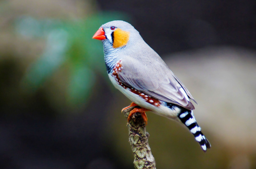

In [6]:
from fastai.vision.all import *
im = Image.open(modelRootFolder + "/bird000001.png")
# icrawler names the downloaded photos from 000001 to 999999
im.to_thumb(256,256)

Looks great! Now let's get a forest photo as well.

In [7]:
search_images("forest", 1, modelRootFolder)

2024-10-17 22:13:21,895 - INFO - icrawler.crawler - start crawling...
2024-10-17 22:13:21,895 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-17 22:13:21,897 - INFO - feeder - thread feeder-001 exit
2024-10-17 22:13:21,898 - INFO - icrawler.crawler - starting 1 parser threads...
2024-10-17 22:13:21,899 - INFO - icrawler.crawler - starting 1 downloader threads...


Searching for 'forest'


2024-10-17 22:13:22,554 - INFO - parser - parsing result page https://www.google.com/search?q=forest&ijn=0&start=0&tbs=&tbm=isch
2024-10-17 22:13:22,818 - INFO - downloader - image #1	https://www.massaudubon.org/var/site/storage/images/9/3/6/2/1602639-1-eng-US/2fe6f73efaea-RE_KForesto-3461-1920x1280.jpg
2024-10-17 22:13:23,094 - INFO - downloader - downloaded images reach max num, thread downloader-001 is ready to exit
2024-10-17 22:13:23,094 - INFO - downloader - thread downloader-001 exit
2024-10-17 22:13:23,903 - INFO - icrawler.crawler - Crawling task done!


Let's look at the forest photo:

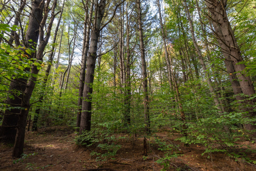

2024-10-17 22:13:24,827 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-10-17 22:13:24,828 - INFO - parser - thread parser-001 exit


In [8]:
im = Image.open(modelRootFolder + "/forest000001.png")
im.to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

This code block may take a few minutes

In [ ]:
## !! IMPORTANT
# This represents the number of photos that'll be downloaded for each category.
# If you don't want to wait you can lower this number so less images will be downloaded.
# Having less images to train on may lead to worse neural network performance.
no_of_photos = 20 # Default is 20

searches = 'forest','bird'
path = Path(modelRootFolder)
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    search_images(f"{o} photo", no_of_photos, dest)
    sleep(10)  # Pause between searches to avoid over-loading server
    search_images(f"{o} sun photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{o} night photo", no_of_photos, dest) 
    # Changed this to get "night photo" instead of "shade photo" since the original would cause paint tones to be downloaded 
    sleep(10)
    print(f"Photos of {o} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

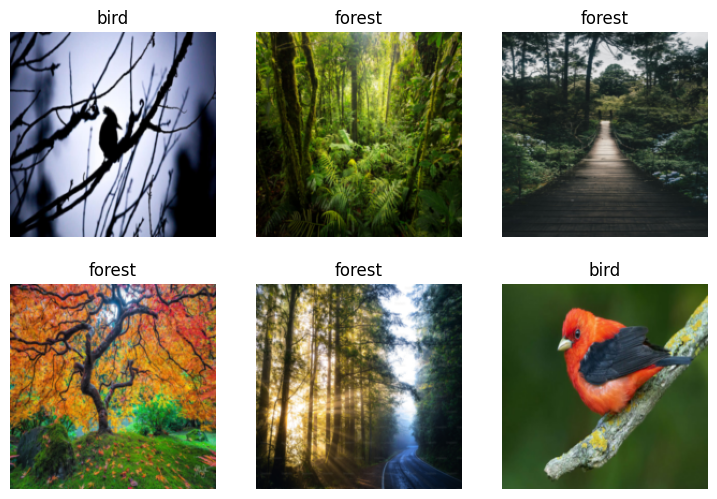

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.868777,1.429681,0.416667,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.794101,1.009481,0.458333,00:02
1,0.553610,0.598570,0.291667,00:02
2,0.419944,0.401856,0.083333,00:02


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [14]:
is_bird,_,probs = learn.predict(PILImage.create(modelRootFolder + "/bird000001.png"))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.8840


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.